## 부족한 정보를 검색하여 Context 보강

절차

- 전통적인 RAG 를 수행
- 검색된 문서에 답변에 필요한 정보가 부족한 경우 -> “웹 검색”을 위한 쿼리 재작성
- “웹 검색” 으로 보충된 정보로 답변 도출 시도
- 새로운 답변으로 관련성 체크 후 재조정/종료 진행

In [1]:
# api key
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LANGGRAPH")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LANGGRAPH


In [3]:
from rag.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(["../12-RAG/data/1568)누구나 한번쯤 읽어야 할 사서삼경 (미리내공방) .pdf"]).create_chain()
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

### GraphState

In [4]:
from typing import TypedDict


# GraphState 상태를 저장하는 용도로 사용합니다.
class GraphState(TypedDict):
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # 답변
    relevance: str  # 답변의 문서에 대한 관련성

### 노드와 엣지

우리는 agentic RAG 그래프를 다음과 같이 구성할 수 있습니다:

- 상태는 메시지의 집합입니다
- 각 노드는 상태를 업데이트(추가)합니다
- 조건부 엣지는 다음에 방문할 노드를 결정합니다

In [5]:
from langchain_upstage import UpstageGroundednessCheck
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools.tavily_search import TavilySearchResults
from rag.utils import format_docs, format_searched_docs

# 업스테이지 문서 관련성 체크 기능을 설정합니다. https://upstage.ai
upstage_ground_checker = UpstageGroundednessCheck()


# 문서에서 검색하여 관련성 있는 문서를 찾습니다.
def retrieve_document(state: GraphState) -> GraphState:
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(state["question"])

    # 검색된 문서를 형식화합니다.
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# LLM을 사용하여 답변을 생성합니다.
def llm_answer(state: GraphState) -> GraphState:
    question = state["question"]
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke({"question": question, "context": context})

    return GraphState(answer=response)


def rewrite(state):
    question = state["question"]
    answer = state["answer"]
    context = state["context"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a professional prompt rewriter. Your task is to generate the question in order to get additional information that is now shown in the context."
                "Your generated question will be searched on the web to find relevant information.",
            ),
            (
                "human",
                "Rewrite the question to get additional information to get the answer."
                "\n\nHere is the initial question:\n ------- \n{question}\n ------- \n"
                "\n\nHere is the initial context:\n ------- \n{context}\n ------- \n"
                "\n\nHere is the initial answer to the question:\n ------- \n{answer}\n ------- \n"
                "\n\nFormulate an improved question in Korean:",
            ),
        ]
    )

    # Question rewriting model
    model = ChatOpenAI(temperature=0, model="gpt-4-turbo")

    chain = prompt | model | StrOutputParser()
    response = chain.invoke(
        {"question": question, "answer": answer, "context": context}
    )
    return GraphState(question=response)


def search_on_web(state: GraphState) -> GraphState:
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    search_tool = TavilySearchResults(max_results=5)
    search_result = search_tool.invoke({"query": state["question"]})

    # 검색된 문서를 형식화합니다.
    search_result = format_searched_docs(search_result)
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(
        context=search_result,
    )


def relevance_check(state: GraphState) -> GraphState:
    print("relevance_check", state)
    # 관련성 체크를 실행합니다. 결과: grounded, notGrounded, notSure
    response = upstage_ground_checker.run(
        {"context": state["context"], "answer": state["answer"]}
    )
    return GraphState(
        relevance=response, question=state["question"], answer=state["answer"]
    )


def is_relevant(state: GraphState) -> GraphState:
    return state["relevance"]

In [6]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve_document)  # 에이전트 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 정보 검색 노드를 추가합니다.
workflow.add_node(
    "relevance_check", relevance_check
)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.
workflow.add_node("rewrite", rewrite)  # 질문을 재작성하는 노드를 추가합니다.
workflow.add_node("search_on_web", search_on_web)  # 웹 검색 노드를 추가합니다.

# 각 노드들을 연결합니다.
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", "relevance_check")  # 답변 -> 관련성 체크
workflow.add_edge("rewrite", "search_on_web")  # 재작성 -> 관련성 체크
workflow.add_edge("search_on_web", "llm_answer")  # 웹 검색 -> 답변


# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "grounded": END,  # 관련성이 있으면 종료합니다.
        "notGrounded": "rewrite",  # 관련성이 없으면 다시 답변을 생성합니다.
        "notSure": "rewrite",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)


workflow.set_entry_point("retrieve")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

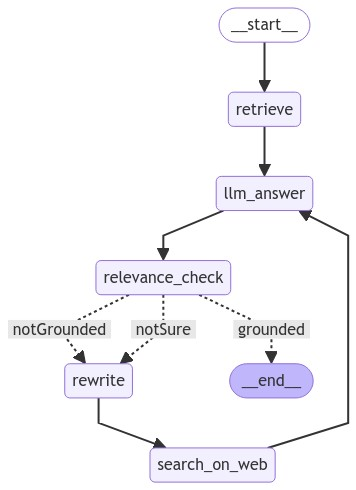

In [7]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [9]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
)

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(
    question="논어에서 공자가 한 말중 가장 중요한 부분은 무엇입니까"
)

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

"Output from node 'retrieve':"
'---'
{ 'context': '<document><content>차\n'
             '례\n'
             '머리말 … 5\n'
             '論\n'
             '논어란? …12\n'
             '語\n'
             '성인 공자 16 | 평생 학문에 뜻을 두고 18 | 무덤만이 사람이 쉴 곳 20 | 군자는 고\n'
             '루 나누어준다 24 | 임금 자리도 마다한 사람 27 | 사냥하면서도 인을 생각하라\n'
             '29 | 공자가 가장 아낀 제자, 안회 31 | 보배로운 그릇 같은 존재 33 | 배우는 사람\n'
             '의 마음가짐 35 | 팔일무 사건 38 | 예로써 다스리는 나라 40 | 공자의 식생활 44 |\n'
             '공자의 의생활 48 | 공자가 두려워하고 멀리한 것들 50 | 인에 대하여 53 | 군자에\n'
             '대하여 57 | 곧은 마음의 본보기, 백이와 숙제 61 | 공자의 일상생활 64 | 《논어》\n'
             '의 명구절 66\n'
             '孟\n'
             '맹자란? …98\n'
             '子\n'
             '오십보백보 102 | 인자무적 106 | 40리나 되는 거대한 함정 108 | 성선설에 대하\n'
             '여 112 | 나라를 잘못 다스린 죄 115 | 인으로써 구해야 정도 117 | 군자의 '
             '합리적</content><source>../12-RAG/data/1568)누구나 한번쯤 읽어야 할 사서삼경 '
             '(미리내공방) .pdf</source><page>9</page></document>\n'
             '<document><content>전10장: 치국

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
print(output["relevance_check"]["question"])
print(output["relevance_check"]["answer"])
print(output["relevance_check"]["relevance"])